### Load packages

In [1]:
using Revise, Reachability, LazySets, MathematicalSystems, Dates, BenchmarkTools

In [2]:
now()

2019-10-30T05:49:43.737

In [3]:
1 + 1

2

### Running Example

In [4]:
# Example from Althoff's thesis, section 3.2.3
# x' = Ax + u
A = [-1 -4  0  0  0;
      4 -1  0  0  0;
      0  0 -3  1  0;
      0  0  -1 -3 0;
      0  0   0 0  -2.]

X0 = Hyperrectangle(low=fill(0.9, 5), high=fill(1.1, 5));

U = Hyperrectangle(low=[0.9, -0.25, -0.1, 0.25, -0.75], high=[1.1, 0.25, 0.1, 0.75, -0.25])

# empty (for debugging purposes)
#U = ZeroSet(5)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([1.0, 0.0, 0.0, 0.5, -0.5], [0.10000000000000009, 0.25, 0.1, 0.25, 0.25])

## Upstream (type-unstable) algorithm

In [5]:
# x' = Ax + u, u ∈ U
S = ConstrainedLinearControlContinuousSystem(A, I(5), Universe(5), U)
P = InitialValueProblem(S, X0)
opts = Options(:T=>5.0)
opts_algo = Options(:δ=>0.01, :vars=>[2, 3]);

In [6]:
sol = solve(P, opts, op=BFFPSV18(opts_algo));

Computing successors 100%|██████████████████████████████| Time: 0:00:02


In [7]:
@btime solve($P, $opts, op=BFFPSV18($opts_algo));
#    for Example 3.2.3 in Althoff's thesis
#   436.155 ms (95355 allocations: 4.96 MiB)

  399.657 ms (95354 allocations: 4.96 MiB)


In [45]:
using Plots

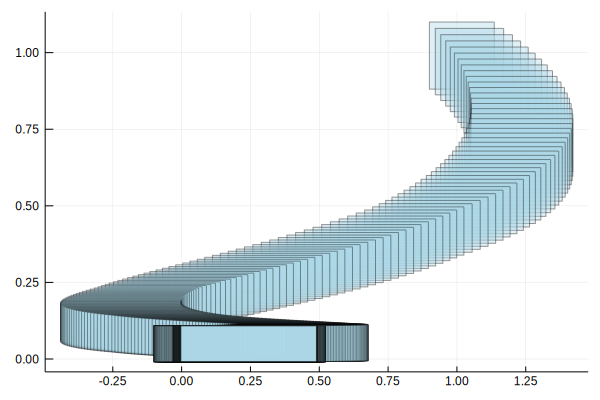

In [51]:
# with input
plot([set(sol.Xk[i]) for i in eachindex(sol.Xk)], color=:lightblue, alpha=0.4)

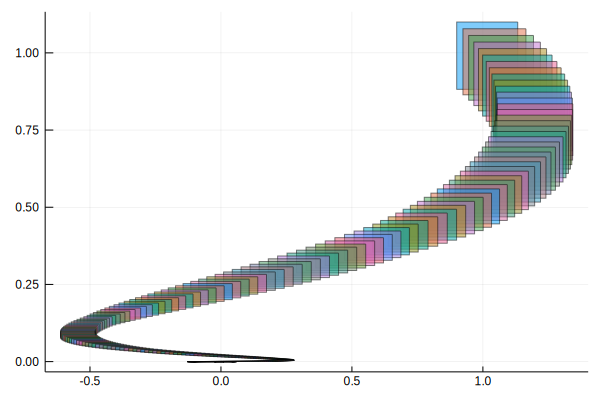

In [16]:
# the following plot shows that if there is no input, the sets are smaller
# U = 0
plot([set(sol.Xk[i]) for i in eachindex(sol.Xk)])

In [21]:
length(sol.Xk)

500

## Type-stable algorithm

We reuse some functions from the notebook BFFPSV18_homog.ipynb which treats the homogeneous case.

In [24]:
include("BFFPSV18.jl");

In [65]:
# x' = Ax + u, u ∈ U
#S = ConstrainedLinearControlContinuousSystem(A, I(5), Universe(5), U)
#S = ConstrainedLinearControlContinuousSystem(MMatrix{5,5,Float64}(A), I(5), Universe(5), ZeroSet(5))
S = ConstrainedLinearControlContinuousSystem(A, I(5), Universe(5), U)

# x' = Ax
#S = LinearContinuousSystem(A)

P = InitialValueProblem(S, X0)
opts = Options(:T => 5.0,
               :δ => 0.01,
               :N => 500,  # el N se puede sacar de T y de delta
               :vars=>[2, 3],
               :partition => [[1], [2], [3], [4], [5]],
               :set_type => Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}},
               #:set_type => Interval{Float64, IA.Interval{Float64}},
               :row_blocks => [[2], [3]],
               :column_blocks => [[1], [2], [3], [4], [5]],
               :num_type => Float64,
               :block_indices => [2, 3]);
# varias de las opciones anteriores se pueden deducir de otras!

In [66]:
sol = solve_BFFPSV18(P, opts);

In [67]:
@btime solve_BFFPSV18($P, $opts);

# Some results:
#
# GENERIC implementation, using Hyperrectangle ST
#   8.380 ms (50326 allocations: 3.46 MiB)
#
# GENERIC implementation, using Hyperrectangle ST and using an MArray for A
#   4.592 ms (49250 allocations: 3.40 MiB)
#
# GENERIC implementation, using Interval ST (to test this one, comment the dispatch on Interval and restart the kernel..)
#  N/A

# Interval implementation, using Interval ST
#   2.974 ms (15391 allocations: 1.12 MiB)

# Interval implementation, using Interval ST
# using mutable statically sized array
#   1.473 ms (14305 allocations: 1.06 MiB)

  8.380 ms (50326 allocations: 3.46 MiB)


In [61]:
# best speedup is 271x with respect to the upstream implementation:
399.6e-3 / 1.473e-3

271.2830957230143

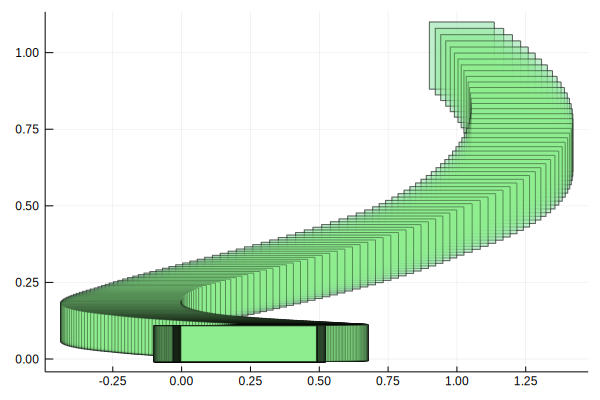

In [54]:
# we plot on the same axes as for the upstream code, to compare the plots
plot!([set(sol[i]) for i in eachindex(sol)], color=:lightgreen, alpha=0.4)

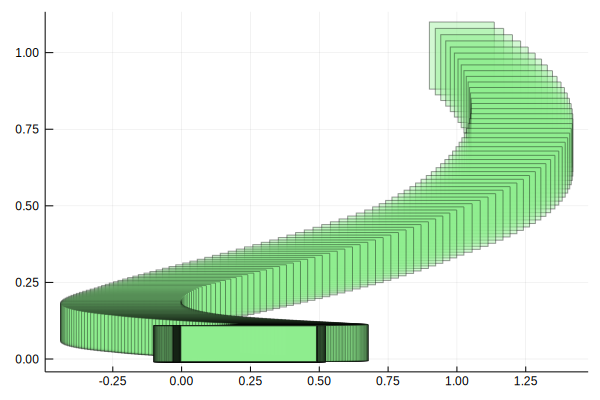

In [46]:
plot([set(sol[i]) for i in eachindex(sol)], color=:lightgreen, alpha=0.4)

  703.199 μs (3285 allocations: 198.81 KiB)


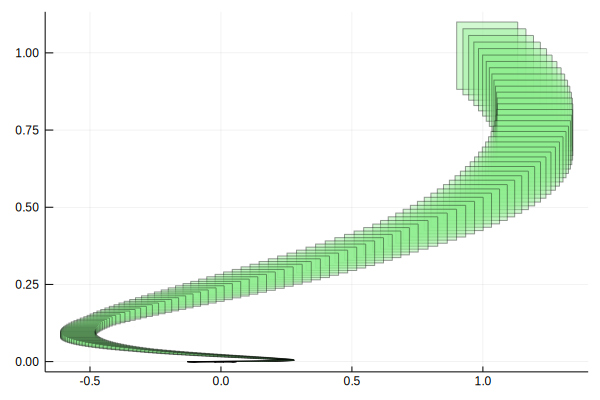

In [73]:
# Some Results with and without inputs:
# using LinearContinuous system:
#  703.199 μs (3285 allocations: 198.81 KiB)

# using ConstrainedLinearControlContinuousSystem but with U = 0
# Interval ST
# 2.538 ms (11345 allocations: 860.36 KiB)

# --------
# U = 0
# --------

# x' = Ax
S = LinearContinuousSystem(A)

# x' = Ax + u, u ∈ U = 0
#S = ConstrainedLinearControlContinuousSystem(A, I(5), Universe(5), ZeroSet(5))


P = InitialValueProblem(S, X0)
opts = Options(:T => 5.0,
               :δ => 0.01,
               :N => 500,  # el N se puede sacar de T y de delta
               :vars=>[2, 3],
               :partition => [[1], [2], [3], [4], [5]],
               #:set_type => Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}},
               :set_type => Interval{Float64, IA.Interval{Float64}},
               :row_blocks => [[2], [3]],
               :column_blocks => [[1], [2], [3], [4], [5]],
               :num_type => Float64,
               :block_indices => [2, 3]);
# varias de las opciones anteriores se pueden deducir de otras!

sol = solve_BFFPSV18(P, opts);

@btime solve_BFFPSV18($P, $opts);

plot([set(sol[i]) for i in eachindex(sol)], color=:lightgreen, alpha=0.4)